<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Kuleshov-Alexey-folder/15_05_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_1_%D0%9A%D0%90%D0%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача**
1. **ОТКАЗ** если, [**D**зрачка // **D**радужной_оболочки == 0,5]  ---> `система идентификации возвращает «невозможность идентификации», т е область радужной оболочки слишком мала для возможности точной идентификации.`
2. Сеть классификации возвращает вероятность класса для правого глаза. Затем
подается изображение переднего сегмента левого глаза пациента и снова
возвращается вероятность класса.

т.е. для распознания изображения???

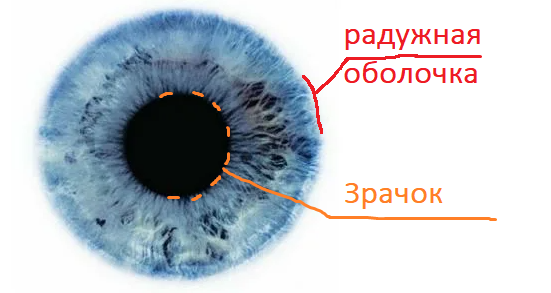

**1.Загрузка Библиотек**

In [1]:
from tensorflow.keras.models import Sequential      # Подлючение класса создания модели Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam        # Подключение оптимизатора Adam
from tensorflow.keras import utils                  # Утилиты для to_categorical
# Для отрисовки изображения
from tensorflow.keras.preprocessing import image 
# Метод для загрузки изображений
from tensorflow.keras.preprocessing.image import load_img   
# Подключение библиотеки numpy
import numpy as np     
# Генерация случайных чисел                              
import random                                       
# Математические функции
import math                                        
# Модуль для построения графиков
import pylab            
# Для загрузки своей картинки                            
from google.colab import files
# Отрисовка изображений                      
import matplotlib.pyplot as plt         
# Отрисовка изображений, ImageEnhance содержит дополнительные инструменты для манипуляций с изображениями            
from PIL import Image, ImageEnhance                 
import gdown
# Работа с файлами
import os
# Отрисовка изображения в ноутбуке, а не в консоли или файле
%matplotlib inline

**2. ИСХОДНЫЕ ДАННЫЕ**

In [2]:
#  Доступ на диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_1 = '/content/drive/MyDrive/!Стажировка/01ТРУД/База_1/'  # База данных 1 рабочая. zip файлы

In [ ]:
DATASET_2 = 'https://drive.google.com/drive/folders/1wcfbPNhttWrLCRVEKZwh2uEToCsLdWyc?usp=share_link' # База сет2. Разархивированные 2-х размеров 640х480 и 1920х1080

In [ ]:
DATASET_3 = 'https://cloud.mail.ru/public/wHUX/6AN6LGoY3' # База сет3 от 28.04.2023 + 10 пациентов. Размер - 1920x1080

In [8]:
# Папка для разархивации
PATH_folder = '/content/Ochi'
# Папка для тренировочной выборки
PATH_TRAIN = '/content/Ochi_train'
# Папка для тестировочной выборки
PATH_TEST = '/content/Ochi_test'

**2.1 ГИПЕРПАРАМЕТРЫ**

In [4]:
TEST_SPLIT = 0.2   # Доля тестовых данных в общем наборе
VAL_SPLIT= 0.2     # Доля проверочной выборки в обучающем наборе

**2. Предобработка**

In [5]:
# загрузка Базы 1
!wget -q {DATASET_1}

In [18]:
# Разархивация датасета 1 в папку_тренировочной выборки
!unzip -q '{DATASET_1}''iris*' -d {PATH_folder}


8 archives were successfully processed.


In [19]:
# Создаем папки для каждого класса и перемещаем файлы в соответствующую папку
for i in range(1, 65):
                        class_folder = os.path.join(PATH_folder, f'{i:03}')
                        if not os.path.exists(class_folder):
                            os.makedirs(class_folder)
                        for file_name in ['%03dL_%d.png' % (i, j) for j in range(1, 4)] + ['%03dR_%d.png' % (i, j) for j in range(1, 4)]:
                            file_path = os.path.join(PATH_folder, file_name)
                            if os.path.exists(file_path):
                                os.replace(file_path, os.path.join(class_folder, file_name))

In [20]:
# Определяем перечень меток классов
CLASS_folder = sorted(os.listdir(PATH_folder))
# Определение количества классов, равное количеству папок
CLASS_N = len(CLASS_folder)
print(f'Количество классов {CLASS_N}, метки класса {CLASS_folder}')

Количество классов 64, метки класса ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064']


In [21]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(PATH_TEST)                                        # Создание папки для тестовых данных

train_count = 0
test_count = 0


for class_name in CLASS_folder:                            # Для всех классов по порядку номеров (их меток)
    class_path = f'{PATH_folder}/{class_name}'             # Формирование полного пути к папке с изображениями класса
    test_path = f'{PATH_TEST}/{class_name}'              # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_files.sort()                                     # Сортировка имен файлов по алфавиту
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора
    print(f'Номер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Номер класса 001: 6 фото, для теста выделено файлов: 1
Номер класса 002: 6 фото, для теста выделено файлов: 1
Номер класса 003: 6 фото, для теста выделено файлов: 1
Номер класса 004: 6 фото, для теста выделено файлов: 1
Номер класса 005: 6 фото, для теста выделено файлов: 1
Номер класса 006: 6 фото, для теста выделено файлов: 1
Номер класса 007: 6 фото, для теста выделено файлов: 1
Номер класса 008: 6 фото, для теста выделено файлов: 1
Номер класса 009: 6 фото, для теста выделено файлов: 1
Номер класса 010: 6 фото, для теста выделено файлов: 1
Номер класса 011: 6 фото, для теста выделено файлов: 1
Номер класса 012: 6 фото, для теста выделено файлов: 1
Номер класса 013: 6 фото, для теста выделено файлов: 1
Номер класса 014: 6 фото, для теста выделено файлов: 1
Номер класса 015: 6 фото, для теста выделено файлов: 1
Номер класса 016: 6 фото, для теста выделено файлов: 1
Номер класса 017: 6 фото, для теста выделено файлов: 1
Номер класса 018: 6 фото, для теста выделено файлов: 1
Номер клас

# Превышение зрачка над радужной оболочкой/
# 1 попытка

In [34]:
# Загружаем библиотеки
import cv2
import numpy as np
from skimage import measure
from skimage.measure import regionprops

In [23]:
# Загрузите фото глаза в скрипт и преобразуйте его в черно-белый формат.
img = cv2.imread('/content/Ochi/001/001L_1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [26]:
# Выполните бинаризацию изображения, чтобы определить границы зрачка и радужной оболочки.
limit = 150   #пороговое значение
binary = cv2.threshold(gray, limit, 255, cv2.THRESH_BINARY)[1]  #Затем для серого изображения gray выполняется операция бинаризации(черно-белое) с помощью функции cv2

In [27]:
# Определите радужную оболочку заданного изображения
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)    # находим границы заданного бинарного изображения
radius = 0
for cnt in contours:
    (x, y), r = cv2.minEnclosingCircle(cnt)            # Вычисляется минимальная окружность, описывающая контур
    areal = cv2.contourArea(cnt)                       # Находим площадь контура
    if areal > 0 and r > radius:                       # Смотрим площадь>0 и радиуса найденной минимальной окружности
        radius = r
        center = (int(x), int(y))
cv2.circle(img, center, int(radius), (255, 0, 0), 2)   # Рисуем круг с центром center и радиусом radius чтобы обозначить область контура

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [29]:
# Определите диаметр радужной оболочки
diameter_iris = 2 * radius
print(diameter_iris)

In [48]:
# Определите диаметр зрачка и проверьте, соответствует ли он требуемому уровню
labeled = measure.label(binary, background=0)
regions = regionprops(labeled)
diameters = [region.equivalent_diameter for region in regions]
diameter_pupil = np.median(diameters)

if diameter_pupil < diameter_iris / 2:
    print("Отказ! Диаметр зрачка в дава раза меньше, чем диаметр радужной оболочки.")
else:
    print("Принято. Диаметр зрачка соответствует требованиям.")

Отказ! Диаметр зрачка в дава раза меньше, чем диаметр радужной оболочки.


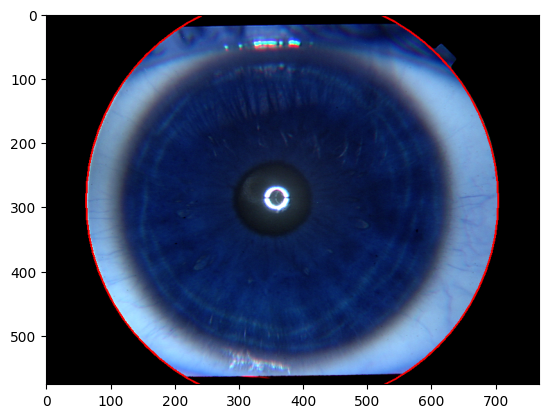

In [44]:
plt.imshow(img)
plt.show()

оригинал 033L_1.png


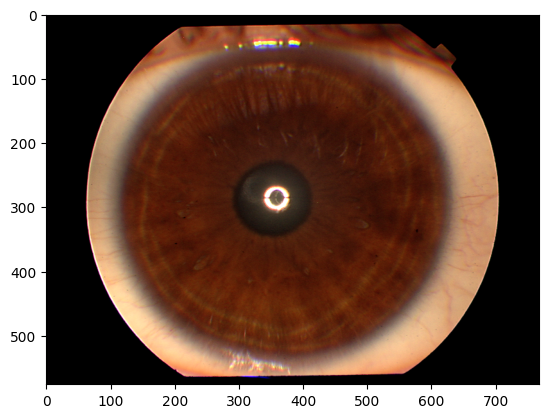

In [46]:
with Image.open('/content/Ochi/001/001L_1.png') as img33_L:
    print('оригинал 033L_1.png')
    plt.imshow(img33_L) 